In [85]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import datasets, linear_model, metrics, preprocessing

In [181]:
input_data_dir = os.getcwd().replace('/notebooks', '') + '/data/interim'
output_data_dir = os.getcwd().replace('/notebooks', '') + '/data/processed'

interim_modeling_df = pd.read_csv("{}/step3_interim_modeling_data.csv".format(input_data_dir))

invalid_preds = ["school_name", "dbn", "Address (Full)", "City", "Grades", "Grade Low", "Grade High", \
    "SED Code", "Latitude", "Longitude", "Zip"]
response_vars = ["num_testtakers", "num_offered", "pct_8th_graders_offered", "perc_testtakers", "perc_testtakers_quartile"]
response_var = "perc_testtakers"
response_df_cols = ["dbn", response_var]
response_df = interim_modeling_df[response_df_cols]

pred_df = interim_modeling_df.drop(response_df_cols, axis=1)

model_1_pred_train, model_2_pred_train, model_1_response_train, model_2_response_train = \
    train_test_split(pred_df, response_df, test_size=0.5, random_state=223)

In [182]:
pred_cols = [
    #"school_name", "dbn", # only incl these two for convenience in ID'ing rows
    "Average ELA Proficiency", 
    "Average Math Proficiency", 
    "sa_attendance_90plus_2017_city_diff", 
    "min_dist_to_big_three",
    'borough_bronx',
    'borough_manhattan', 
    'borough_queens', 
    'borough_staten_island',
#     'Student Achievement Rating_Approaching Target',
#     'Student Achievement Rating_Exceeding Target',
#     'Student Achievement Rating_Not Meeting Target',
#     'Student Achievement Rating_nan',
    "discretionary_funding"#,
    #"Vio N"
]
model_1_final_pred_df = model_1_pred_train[pred_cols]
model_2_final_pred_df = model_2_pred_train[pred_cols]

In [183]:
for pred_col in model_1_final_pred_df.columns.values:
    if model_1_final_pred_df[pred_col].dtype == "float64":
        scaler = preprocessing.StandardScaler().fit(model_1_final_pred_df[[pred_col]])
        train_col_scaled = scaler.transform(model_1_final_pred_df[[pred_col]])
        test_col_scaled = scaler.transform(model_2_final_pred_df[[pred_col]])
        model_1_final_pred_df["{}_stdized".format(pred_col)] = train_col_scaled
        model_2_final_pred_df["{}_stdized".format(pred_col)] = test_col_scaled
        model_1_final_pred_df = model_1_final_pred_df.drop(pred_col, axis=1)
        model_2_final_pred_df = model_2_final_pred_df.drop(pred_col, axis=1)

/Users/greg.bolla/.local/share/virtualenvs/kaggle-passnyc-hqRn-hsS/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/greg.bolla/.local/share/virtualenvs/kaggle-passnyc-hqRn-hsS/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [184]:
model_1 = linear_model.LinearRegression().fit(model_1_final_pred_df, model_1_response_train[response_var])
model_1_train_predicted = model_1.predict(model_1_final_pred_df)
model_1_test_predicted = model_1.predict(model_2_final_pred_df)

model_2 = linear_model.LinearRegression().fit(model_2_final_pred_df, model_2_response_train[response_var])
model_2_test_predicted = model_2.predict(model_1_final_pred_df)

In [185]:
test2 = model_1_response_train
test2["predicted_prop_as_test"] = model_2_test_predicted
test2["pred_diff_from_actual"] = test2["perc_testtakers"] - test2["predicted_prop_as_test"]
print(test2["pred_diff_from_actual"].describe())

all_test = pd.concat([test, test2])
print(all_test.describe())

count    282.000000
mean      -0.003406
std        0.149404
min       -0.453303
25%       -0.103230
50%       -0.023041
75%        0.078861
max        0.757998
Name: pred_diff_from_actual, dtype: float64
       perc_testtakers  predicted_prop_as_test  pred_diff_from_actual
count       565.000000              565.000000             565.000000
mean          0.294862                0.294462               0.000400
std           0.235512                0.182505               0.153409
min           0.000000               -0.064607              -0.542837
25%           0.134409                0.154776              -0.088854
50%           0.247619                0.264010              -0.012816
75%           0.409091                0.408452               0.079515
max           1.560000                0.948394               0.757998


/Users/greg.bolla/.local/share/virtualenvs/kaggle-passnyc-hqRn-hsS/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/greg.bolla/.local/share/virtualenvs/kaggle-passnyc-hqRn-hsS/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


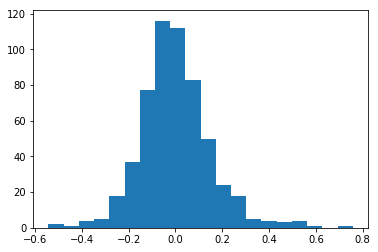

In [186]:
import matplotlib.pyplot as plt

num_bins = 20
plt.hist(all_test["pred_diff_from_actual"], num_bins)
plt.show()


In [187]:
model_1_coefficients = pd.concat([pd.DataFrame(model_1_final_pred_df.columns),pd.DataFrame(np.transpose(model_1.coef_))], axis = 1)
model_1_coefficients                                
                                
                                 

,0,0
0,borough_bronx,0.015009
1,borough_manhattan,-0.051948
2,borough_queens,-0.023202
3,borough_staten_island,-0.088683
4,Average ELA Proficiency_stdized,0.081579
5,Average Math Proficiency_stdized,0.093753
6,sa_attendance_90plus_2017_city_diff_stdized,0.027096
7,min_dist_to_big_three_stdized,-0.010867
8,discretionary_funding_stdized,0.014857


In [188]:
print(metrics.median_absolute_error(all_test["perc_testtakers"],all_test["predicted_prop_as_test"]))
print(metrics.r2_score(all_test["perc_testtakers"],all_test["predicted_prop_as_test"]))

def adj_r2_score(lm, y, y_pred):
    adj_r2 = 1 - float(len(y)-1)/(len(y)-len(lm.coef_)-1)*(1 - metrics.r2_score(y,y_pred))
    return adj_r2

print(adj_r2_score(model_1, all_test["perc_testtakers"],all_test["predicted_prop_as_test"]))

0.08376295090857039
0.5756907227950678
0.5688100318133662


In [81]:
def get_categorical_model(col_name, pred_train_df, response_train_df):
    model_rows = []
    
    col_list = pred_train_df.columns.values
    
    col_dummy_vars = [var for var in col_list if "{}_".format(col_name) in var]
    x_train_df = pred_train_df[col_dummy_vars]
    x_train_df = sm.add_constant(x_train_df)

    x_model = sm.OLS(response_train_df, x_train_df, missing='drop')
    x_results = x_model.fit()
    
    num_obs = x_results.nobs
    r2 = x_results.rsquared
    adj_r2 = x_results.rsquared_adj
    f_stat = x_results.fvalue
    f_stat_pval = x_results.f_pvalue
    aic = x_results.aic
    bic = x_results.bic
    for i, pred_pval in enumerate(x_results.pvalues):
        if np.isnan(pred_pval):
            print(x_results.summary())
            continue
        model_row = {}
        model_row['model'] = col_name
        if len(x_results.pvalues[x_results.pvalues == pred_pval]) > 1:
            print(x_results.pvalues[x_results.pvalues == pred_pval])
            raise ValueError('multiple preds have same pval')
        pred_col = x_results.pvalues[x_results.pvalues == pred_pval].index[0]
        pred_coef = x_results.params[pred_col]
        
        
        model_row['model_r2'] = r2
        model_row['model_adj_r2'] = adj_r2
        model_row['model_f_stat'] = f_stat
        model_row['model_f_stat_pval'] = f_stat_pval
        model_row['model_aic'] = aic
        model_row['model_bic'] = bic
        model_row['pred_col'] = pred_col
        model_row['pred_coef'] = pred_coef
        model_row['pred_col_pval'] = pred_pval
        if pred_col != 'const':
            model_row['pred_num_miss'] = pred_train_df[pred_col].isnull().sum()
        model_rows.append(model_row)

    return model_rows

def get_numerical_model(col_name, pred_train_df, response_train_df):
    model_rows = []
    
    x_train_df = pred_train_df[col_name]
    x_train_df = sm.add_constant(x_train_df)

    x_model = sm.OLS(response_train_df, x_train_df, missing='drop')
    x_results = x_model.fit()
    
    num_obs = x_results.nobs
    r2 = x_results.rsquared
    adj_r2 = x_results.rsquared_adj
    f_stat = x_results.fvalue
    f_stat_pval = x_results.f_pvalue
    aic = x_results.aic
    bic = x_results.bic
    for i, pred_pval in enumerate(x_results.pvalues):
        if np.isnan(pred_pval):
            print(x_results.summary())
            continue
        model_row = {}
        model_row['model'] = col_name
        if len(x_results.pvalues[x_results.pvalues == pred_pval]) > 1:
            print(x_results.pvalues[x_results.pvalues == pred_pval])
            raise ValueError('multiple preds have same pval')
        pred_col = x_results.pvalues[x_results.pvalues == pred_pval].index[0]
        pred_coef = x_results.params[pred_col]
        
        
        model_row['model_r2'] = r2
        model_row['model_adj_r2'] = adj_r2
        model_row['model_f_stat'] = f_stat
        model_row['model_f_stat_pval'] = f_stat_pval
        model_row['model_aic'] = aic
        model_row['model_bic'] = bic
        model_row['pred_col'] = pred_col
        model_row['pred_coef'] = pred_coef
        model_row['pred_col_pval'] = pred_pval
        if pred_col != 'const':
            model_row['pred_num_miss'] = pred_train_df[pred_col].isnull().sum()
        model_rows.append(model_row)

    return model_rows

In [84]:
numeric_pred_df = pd.DataFrame()
cat_pred_df = pd.DataFrame()
num_pred_df = pd.DataFrame()
 
for col in pred_train.columns.values:
    if col in invalid_preds:
        continue
    elif pred_train[col].dtype == "object":
        pred_rows = get_categorical_model(col, pred_train, response_train)
        cat_pred_df = cat_pred_df.append(pred_rows, ignore_index=True)
    elif pred_train[col].dtype == "float":
        pred_rows = get_numerical_model(col, pred_train, response_train)
        num_pred_df = num_pred_df.append(pred_rows, ignore_index=True)

cat_pred_df_cols = ["model", "model_r2", "model_adj_r2", "model_f_stat", "model_f_stat_pval", "model_aic", "model_bic",
    "pred_col", "pred_coef", "pred_col_pval", "pred_num_miss"
]
cat_pred_df = cat_pred_df[cat_pred_df_cols]

cat_pred_df.to_csv("/Users/greg.bolla/Desktop/git-projects/kaggle-passnyc/models/categorical_single_regression.csv", index=False)
num_pred_df.to_csv("/Users/greg.bolla/Desktop/git-projects/kaggle-passnyc/models/numerical_single_regression.csv", index=False)


ValueError: shapes (449,6) and (449,6) not aligned: 6 (dim 1) != 449 (dim 0)

In [112]:
# invalid_preds = ["school_name", "dbn", "Address (Full)", "City", "Grades", "Grade Low", "Grade High", "SED Code", "Latitude", "Longitude", "Zip"]
# response_vars = ["num_testtakers", "num_offered", "pct_8th_graders_offered", "perc_testtakers", "perc_testtakers_quartile"]
# invalid_preds.extend(response_vars)

# for response in response_vars:
#     if response == "perc_testtakers_quartile":
#         na_fill_val = 1
#     else:
#         na_fill_val = 0
    
#     interim_modeling_df[response] = interim_modeling_df[response].fillna(value=na_fill_val)
    
# interim_pred_df = interim_modeling_df.drop(invalid_preds, axis=1)
# interim_response_df = interim_modeling_df[response_vars]"pct_poverty_2017_val"


array(['Address (Full)', 'Average ELA Proficiency',
       'Average Math Proficiency', 'City', 'Collaborative Teachers %',
       'Collaborative Teachers Rating', 'Community School?', 'District',
       'Economic Need Index', 'Effective School Leadership %',
       'Effective School Leadership Rating', 'Grade High', 'Grade Low',
       'Grades', 'Latitude', 'Longitude', 'Percent Asian',
       'Percent Black', 'Percent Black / Hispanic', 'Percent ELL',
       'Percent Hispanic', 'Percent White',
       'Percent of Students Chronically Absent', 'Rigorous Instruction %',
       'Rigorous Instruction Rating', 'SED Code',
       'Strong Family-Community Ties %',
       'Strong Family-Community Ties Rating',
       'Student Achievement Rating', 'Student Attendance Rate',
       'Supportive Environment %', 'Supportive Environment Rating',
       'Trust %', 'Trust Rating', 'Zip', 'avg_math_proficiency_2017',
       'avg_math_proficiency_2017_city_diff',
       'avg_math_proficiency_2017_comp_

In [101]:
# for pred_col in interim_modeling_df.columns.values:
#     if interim_modeling_df[pred_col].dtype == "float64":
#         if len(interim_modeling_df[pred_col].unique()) == 2 \
#             and 1 in interim_modeling_df[pred_col].unique() \
#             and 0 in interim_modeling_df[pred_col].unique():
#             continue
#     else:
#         print(pred_col)
#         print(interim_modeling_df[pred_col].dtype)
            
#             #interim_modeling_df[pred_col] = interim_modeling_df[pred_col].astype(bool)
#         print("{} - {}".format(pred_col, interim_modeling_df[pred_col].unique()))
#         print("standardizing {}".format(pred_col))
#         scaler = preprocessing.StandardScaler().fit(pred_train[[pred_col]])
#         train_col_scaled = scaler.transform(pred_train[[pred_col]])
#         test_col_scaled = scaler.transform(pred_test[[pred_col]])
#         pred_train["{}_stdized".format(pred_col)] = train_col_scaled
#         pred_test["{}_stdized".format(pred_col)] = test_col_scaled
#         pred_train = pred_train.drop(pred_col, axis=1)
#         pred_test = pred_test.drop(pred_col, axis=1)
# scaler = preprocessing.StandardScaler().fit(pred_train[["Average ELA Proficiency"]])
# example_col_scaled = scaler.transform(pred_train[["Average ELA Proficiency"]])
# pred_train["std_Average ELA Proficiency"] = example_col_scaled
# test_scaled = scaler.transform(pred_test[["Average ELA Proficiency"]])
# pred_test["std_Average ELA Proficiency"] = test_scaled

Address (Full)
object
City
object
Collaborative Teachers Rating
object
Community School?
object
Effective School Leadership Rating
object
Grade High
int64
Grade Low
object
Grades
object
Rigorous Instruction Rating
object
Strong Family-Community Ties Rating
object
Student Achievement Rating
object
Supportive Environment Rating
object
Trust Rating
object
dbn
object
school_name
object
econ_need_index_2017_city_diff_binary
bool
borough
object
Community School?_Yes
bool
Rigorous Instruction Rating_Approaching Target
bool
Rigorous Instruction Rating_Exceeding Target
bool
Rigorous Instruction Rating_Not Meeting Target
bool
Rigorous Instruction Rating_nan
bool
Collaborative Teachers Rating_Approaching Target
bool
Collaborative Teachers Rating_Exceeding Target
bool
Collaborative Teachers Rating_Not Meeting Target
bool
Collaborative Teachers Rating_nan
bool
Supportive Environment Rating_Approaching Target
bool
Supportive Environment Rating_Exceeding Target
bool
Supportive Environment Rating_nan


In [65]:

# string_cols = ['Community School?', 'Rigorous Instruction Rating',
#  'Collaborative Teachers Rating', 'Supportive Environment Rating',
#  'Effective School Leadership Rating',
#  'Strong Family-Community Ties', 'borough', 'Strong Family-Community Ties Rating', 'Trust Rating', 'Student Achievement Rating']
# valid_preds = [x for x in pred_test.columns.values if x not in string_cols]
# print(valid_preds)
# pred_train = pred_train[valid_preds]
# pred_test = pred_test[valid_preds]

['econ_need_index_2017_city_diff_binary', 'pct_black_hispanic_stdized', 'District_stdized', 'Economic Need Index_stdized', 'Percent ELL_stdized', 'Percent Asian_stdized', 'Percent Black_stdized', 'Percent Hispanic_stdized', 'Percent Black / Hispanic_stdized', 'Percent White_stdized', 'Student Attendance Rate_stdized', 'Percent of Students Chronically Absent_stdized', 'Rigorous Instruction %_stdized', 'Collaborative Teachers %_stdized', 'Supportive Environment %_stdized', 'Effective School Leadership %_stdized', 'Strong Family-Community Ties %_stdized', 'Trust %_stdized', 'Average ELA Proficiency_stdized', 'Average Math Proficiency_stdized', 'avg_math_proficiency_2016_stdized', 'avg_math_proficiency_2016_city_diff_stdized', 'avg_math_proficiency_2016_comp_diff_stdized', 'avg_math_proficiency_2017_stdized', 'avg_math_proficiency_2017_city_diff_stdized', 'avg_math_proficiency_2017_comp_diff_stdized', 'black_2016_num_students_stdized', 'black_2017_num_students_stdized', 'econ_need_index_20

In [63]:
#response_train_col = response_train["perc_testtakers"]
#print(response_train_col)
full_model = linear_model.LinearRegression().fit(pred_train, response_train_col)

/Users/greg.bolla/.local/share/virtualenvs/kaggle-passnyc-hqRn-hsS/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [78]:
#test_preds = full_model.predict(pred_test)
full_model = linear_model.LinearRegression().fit(pred_train, response_train_col)
train_predicted = full_model.predict(pred_train)
#pred_test["predicted"] = test_preds


In [79]:
response_test["predicted"] = test_preds
response_train["predicted"] = train_predicted

/Users/greg.bolla/.local/share/virtualenvs/kaggle-passnyc-hqRn-hsS/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/greg.bolla/.local/share/virtualenvs/kaggle-passnyc-hqRn-hsS/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [80]:
response_train

,num_testtakers,num_offered,pct_8th_graders_offered,perc_testtakers,perc_testtakers_quartile,predicted
378,23.0,0.0,0.00,0.247312,2.0,0.273117
37,270.0,29.0,0.07,0.714286,4.0,0.544976
155,0.0,0.0,0.00,0.000000,1.0,0.017454
381,23.0,0.0,0.00,0.294872,3.0,0.351171
193,8.0,0.0,0.00,0.142857,1.0,0.093767
52,179.0,23.0,0.04,0.265185,3.0,0.385726
159,0.0,0.0,0.00,0.000000,1.0,0.256581
372,22.0,0.0,0.00,0.241758,2.0,0.404224
56,169.0,21.0,0.03,0.268680,3.0,0.328280
536,96.0,0.0,0.00,0.294479,3.0,0.245285
